In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import sys
import re
import glob
import suftware as su
from scipy.stats import norm
from scipy.stats import poisson

# Insert mavenn at beginning of path
import sys
path_to_mavenn_local = '../../../../'
sys.path.insert(0,path_to_mavenn_local)

#Load mavenn and check path
import mavenn
print(mavenn.__path__)

e = np.exp(1)
pi = np.pi
def pseudo_log(x,base=e):
    return np.log(x+.5)/np.log(base)

['../../../../mavenn']


In [2]:
# Get in-file
data_dir = '/Users/jkinney/Dropbox/20_mavenn/20.08.16_mpsa_raw_data/'
in_file = data_dir + 'results.brca2_9nt_lib2_rep1.txt'
        
# Create dict to record statistics
stats_dict = {}
        
# Load file
in_df = pd.read_csv(in_file, delimiter='\t', index_col=0)
print(f'Processing {in_file}')

# Remove extraneous columns
del in_df['mis_ct']
del in_df['lib_ct']

in_df.head()

/Users/jkinney/opt/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Processing /Users/jkinney/Dropbox/20_mavenn/20.08.16_mpsa_raw_data/results.brca2_9nt_lib2_rep1.txt


,tot_ct,ex_ct,ss,bc
0,137,4330,GCGGTGAGT,CATGCTAAAAGGCGTACACT
1,133,2640,GAGGTGAGA,CCTCATCGCTTGAGATGTGA
2,130,2582,GAGGTGAGA,TTAGGTCATGTGCAACCTTG
3,126,4,ATGGCCATA,TGGTGCCCGGACAAGTCACC
4,121,2054,AAGGTAAGA,GACACTCTGCTCGTCGATTA


In [3]:
# Marginalize by splice site
data_df = in_df.groupby('ss').sum()
data_df.reset_index(inplace=True)

<AxesSubplot:xlabel='tot_ct', ylabel='Count'>

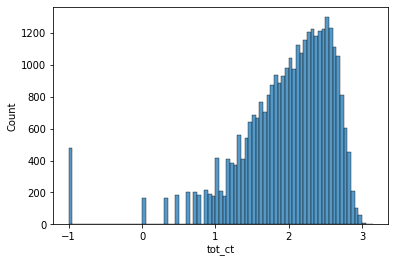

In [4]:
# Look at tot_ct distribution
sns.histplot(np.log10(data_df['tot_ct']+.1))

In [5]:
# Rename columns
data_df.rename(columns={'ss':'x'}, inplace=True)

# Make sequences RNA
data_df['x'] = [ss.replace('T','U') for ss in data_df['x']]

# Remove ss with minimum tot_ct
min_ct = 10
ix = data_df['tot_ct'] >= min_ct
data_df = data_df[ix]
print(f'{(~ix).sum()} ss removed for having tot_ct < {min_ct}')

# Remove ss with invalid sequences
ix = np.array([((x[3]=='G') and (x[4] in {'C','U'})) for x in data_df['x']])
data_df = data_df[ix]
print(f'{(~ix).sum()} ss with invalid sequences removed')

# Compute y
i_n = data_df['tot_ct']
o_n = data_df['ex_ct']
y_n = np.log2((o_n+1)/(i_n+1))
data_df['y'] = y_n

# Assign to trianing and test sets
N = len(data_df)
training_frac=.8
np.random.seed(0)
r = np.random.rand(N)
test_frac = .2
val_frac = .2
ix_train = (test_frac + val_frac <= r)
ix_val = (test_frac <= r) & (r < test_frac + val_frac)
ix_test = (r < test_frac)
data_df['set'] = ''
data_df.loc[ix_train, 'set'] = 'training'
data_df.loc[ix_val, 'set'] = 'validation'
data_df.loc[ix_test, 'set'] = 'test'
assert all([len(x)>0 for x in data_df['set']])

# Shuffle data for extra safety
data_df = data_df.sample(frac=1).reset_index(drop=True)

# Order columns
data_df = data_df[['set', 'tot_ct', 'ex_ct', 'y', 'x']]

# Preview dataframe
print(f'N: {N:,}')
data_df.head(20)

2157 ss removed for having tot_ct < 10
9 ss with invalid sequences removed
N: 30,697


,set,tot_ct,ex_ct,y,x
0,test,541,33,-3.994686,ACAGUUCAU
1,test,153,21,-2.807355,CGCGCCCUU
2,training,358,33,-3.400377,GCAGUUCGA
3,validation,405,41,-3.273018,ACAGCUCCA
4,training,43,0,-5.459432,UCAGCCUUC
5,training,24,4,-2.321928,UAGGUUUUC
6,training,111,3,-4.807355,AUAGUGACU
7,training,298,14,-4.317111,CUAGCCUGU
8,training,216,19,-3.439623,GAUGCCGUA
9,training,10,0,-3.459432,ACGGCAACG


In [6]:
# Show size of compressed dataset file
file_name = 'mpsa_replicate_data.csv.gz'
data_df.to_csv(file_name, compression='gzip', index=False)
print('df (zipped):')
!du -mh $file_name
!mv $file_name ../.

df (zipped):
412K	mpsa_replicate_data.csv.gz


In [7]:
# Test loading
loaded_df = mavenn.load_example_dataset('mpsa_replicate')
loaded_df.head()

,set,tot_ct,ex_ct,y,x
0,test,541,33,-3.994686,ACAGUUCAU
1,test,153,21,-2.807355,CGCGCCCUU
2,training,358,33,-3.400377,GCAGUUCGA
3,validation,405,41,-3.273018,ACAGCUCCA
4,training,43,0,-5.459432,UCAGCCUUC


In [8]:
# Compute lower bound on the intrinsic information in the mpsa data
lib1_df = mavenn.load_example_dataset('mpsa')
print(f'len(lib1_df)={len(lib1_df):,}')

lib2_df = mavenn.load_example_dataset('mpsa_replicate')
print(f'len(lib2_df)={len(lib2_df):,}')
      
# merge datasets
cols = ['x','y']
intersection_df = pd.merge(left=lib1_df[cols], right=lib2_df[cols], on='x', how='inner')
intersection_df.columns = ['x','y1','y2']
print(f'len(intersection_df)={len(intersection_df):,}')
intersection_df.head()

len(lib1_df)=30,483
len(lib2_df)=30,697
len(intersection_df)=29,593


,x,y1,y2
0,AGUGUGCAA,-5.303781,-4.110424
1,UUCGCGCCA,-3.599913,-2.329124
2,UAAGCUUUU,-4.807355,-5.247928
3,AUGGUCGGG,-5.448461,-3.925999
4,AGGGCAGGA,-4.789208,-3.791716


In [9]:
# Compute mutual information
I_intr, dI_intr = mavenn.src.entropy.mi_continuous(intersection_df['y1'], intersection_df['y2'])
print(f'I_intr = {I_intr:.4f} +- {1.96*dI_intr:.4f} bits')

I_intr = 0.4623 +- 0.0179 bits
